In [1]:
!pip install torch torchvision torchaudio
!pip install matplotlib numpy opencv-python pillow
!pip install segmentation-models-pytorch

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/miniconda3/envs/myenv/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/miniconda3/envs/myenv/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/miniconda3/envs/myenv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/miniconda3/envs/myenv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start

In [3]:
!pip install tifffile

Raw image shape: (512, 512)
Label image shape: (512, 512)


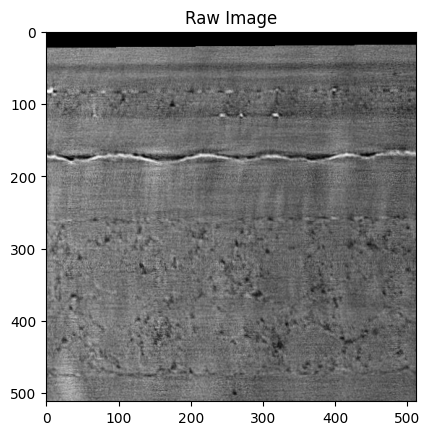

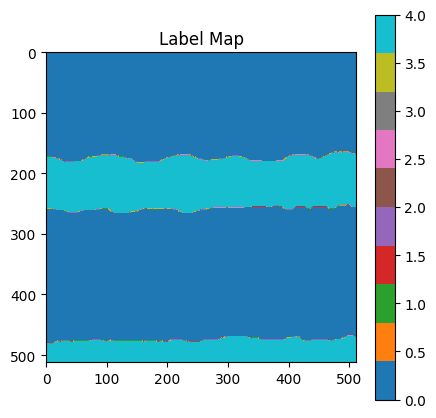

In [4]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import os

# Paths
raw_train_dir = "raw_train"
raw_test_dir = "raw_test"
labels_train_dir = "labels_train"
labels_test_dir = "labels_test"

# choose to look at train or test
use_split = "train"

if use_split == "train":
    raw_dir = raw_train_dir
    label_dir = labels_train_dir
else:
    raw_dir = raw_test_dir
    label_dir = labels_test_dir

# load a sample file
raw_sample_path = os.path.join(raw_dir, sorted(os.listdir(raw_dir))[0])
label_sample_path = os.path.join(label_dir, sorted(os.listdir(label_dir))[0])

# load tiffile
raw_img = tiff.imread(raw_sample_path)
label_img = tiff.imread(label_sample_path)

# check shapes
print("Raw image shape:", raw_img.shape)
print("Label image shape:", label_img.shape)

# visualize the raw file
if raw_img.ndim == 3:
    plt.figure(figsize=(12,4))
    for i in range(min(3, raw_img.shape[2])):
        plt.subplot(1,3,i+1)
        plt.imshow(raw_img[:,:,i], cmap='gray')
        plt.title(f'Band {i+1}')
    plt.show()
else:
    plt.imshow(raw_img, cmap='gray')
    plt.title('Raw Image')
    plt.show()

# visualize label image
plt.figure(figsize=(5,5))
plt.imshow(label_img, cmap='tab10')
plt.title('Label Map')
plt.colorbar()
plt.show()


In [5]:
print("Label dtype:", label_img.dtype)
print("Label shape:", label_img.shape)
print("Unique values:", np.unique(label_img)[:20])

Label dtype: int32
Label shape: (512, 512)
Unique values: [0 4]


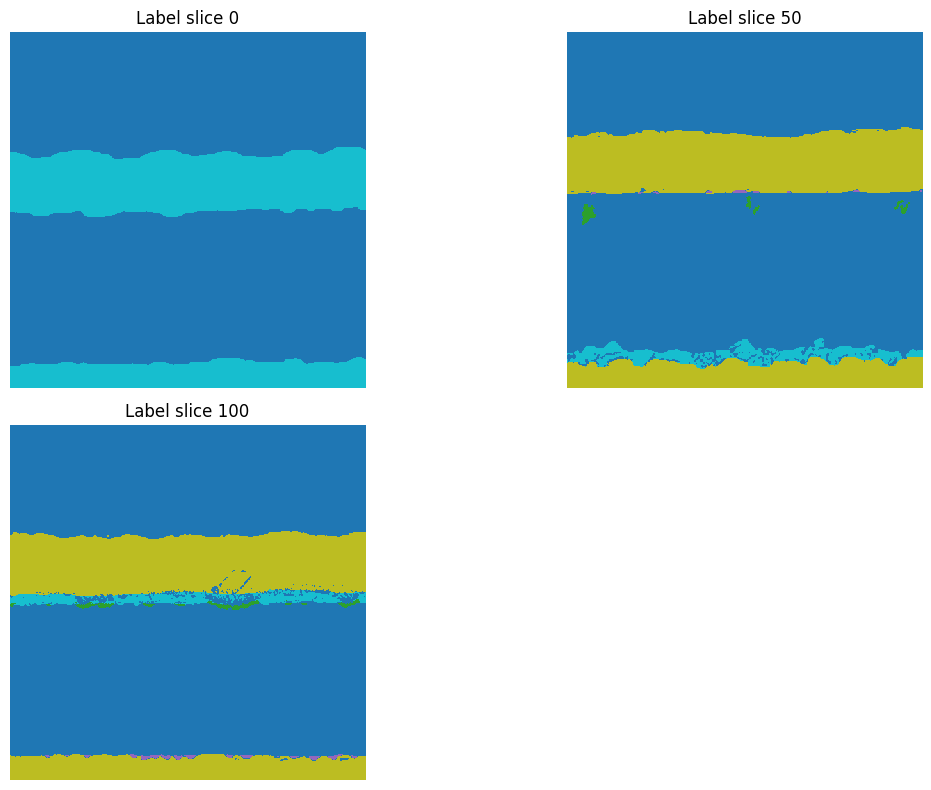

In [7]:
import os
import tifffile as tiff
import matplotlib.pyplot as plt

# choose which split to visualize
use_split = "train" 

if use_split == "train":
    label_dir = "labels_train"
else:
    label_dir = "labels_test"

# get all label image paths
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.tif')])

# pick specific indices to visualize 
slices_to_show = [0, 50, 100, 150] 

# plot the label slices
plt.figure(figsize=(12, 8))
for i, idx in enumerate(slices_to_show, 1):
    if idx < len(label_files):
        label_img = tiff.imread(label_files[idx])
        plt.subplot(2, 2, i)
        plt.imshow(label_img, cmap='tab10', interpolation='nearest')
        plt.title(f'Label slice {idx}')
        plt.axis('off')
plt.tight_layout()
plt.show()


Found 143 raw slices and 143 label slices


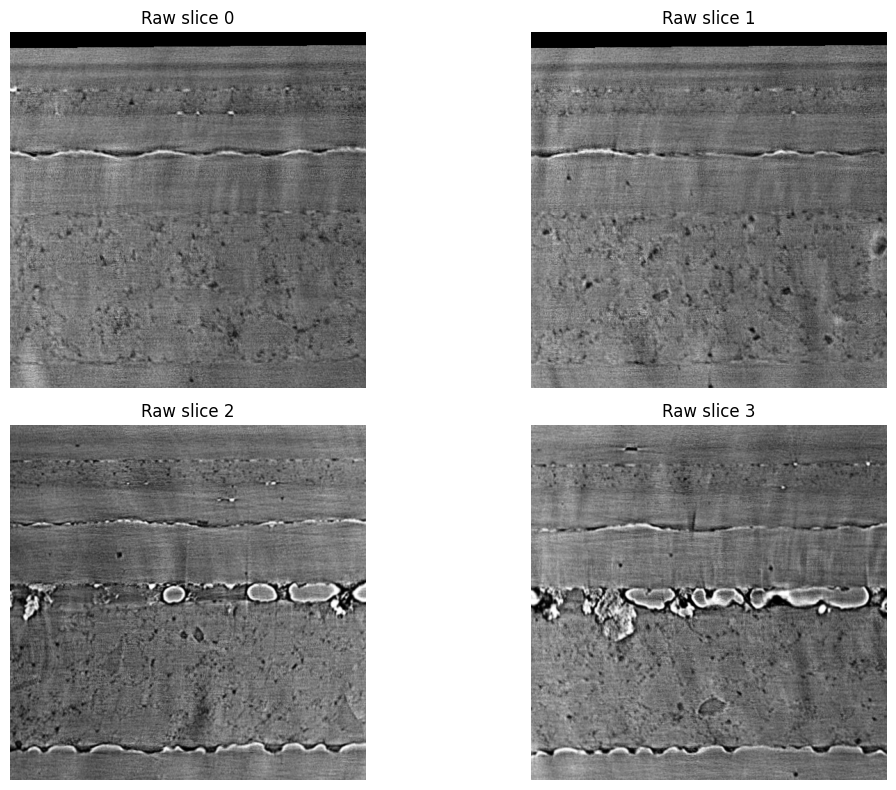

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os

# paths
raw_train_dir = "raw_train"
labels_train_dir = "labels_train"

# sorted lists of file paths
raw_files = sorted([os.path.join(raw_train_dir, f) for f in os.listdir(raw_train_dir) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_train_dir, f) for f in os.listdir(labels_train_dir) if f.endswith('.tif')])

print(f"Found {len(raw_files)} raw slices and {len(label_files)} label slices")

# load some raw images to visualize
n_slices = min(4, len(raw_files))
plt.figure(figsize=(12, 8))
for i in range(n_slices):
    raw_img = tiff.imread(raw_files[i])
    plt.subplot(2, 2, i + 1)
    if raw_img.ndim == 2:
        plt.imshow(raw_img, cmap="gray")
    elif raw_img.ndim == 3:
        plt.imshow(raw_img)
    plt.title(f"Raw slice {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Raw stack shape: (143, 512, 512)
Label stack shape: (143, 512, 512)


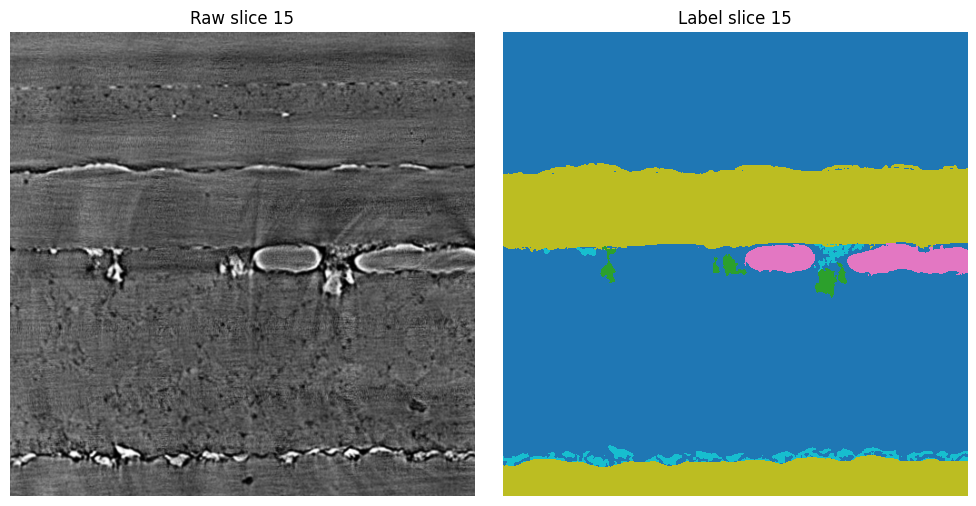

In [9]:
assert len(raw_files) == len(label_files), "Mismatch between raw and label slices"

# load all slices into stacks
raw_stack = np.stack([tiff.imread(f).astype(np.float32) for f in raw_files])
label_stack = np.stack([tiff.imread(f).astype(np.int64) for f in label_files])

print("Raw stack shape:", raw_stack.shape)
print("Label stack shape:", label_stack.shape)

# normalize raw intensities to [0, 1]
raw_norm = (raw_stack - np.min(raw_stack)) / (np.max(raw_stack) - np.min(raw_stack) + 1e-8)

# randdom slice ot see if the images are aligned
idx = np.random.randint(0, raw_stack.shape[0])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(raw_norm[idx], cmap="gray")
plt.title(f"Raw slice {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(label_stack[idx], cmap="tab10", interpolation="nearest")
plt.title(f"Label slice {idx}")
plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
#cell 3
!pip install torch torchvision segmentation-models-pytorch tqdm


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# classes are the unique label values
NUM_CLASSES = len(np.unique(label_stack))
print("Classes:", NUM_CLASSES)


Using device: cpu
Classes: 6


In [12]:
class BatterySegDataset(Dataset):
    def __init__(self, raw_dir, label_dir, transform=True):
        self.raw_files = sorted([os.path.join(raw_dir, f) for f in os.listdir(raw_dir) if f.endswith('.tif')])
        self.label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.tif')])
        assert len(self.raw_files) == len(self.label_files), "Raw and label counts differ!"
        self.transform = transform

    def __len__(self):
        return len(self.raw_files)

    def __getitem__(self, idx):
        x = tiff.imread(self.raw_files[idx]).astype(np.float32)
        y = tiff.imread(self.label_files[idx]).astype(np.int64)

        # normalize to [0, 1]
        x = (x - x.min()) / (x.max() - x.min() + 1e-8)

        # add channel dimension
        if x.ndim == 2:
            x = np.expand_dims(x, axis=0)  # [1, H, W]
        elif x.ndim == 3 and x.shape[0] != 3:
            x = np.transpose(x, (2, 0, 1))  # [C, H, W] 

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y


In [13]:
# using the pre split data folders
train_dataset = BatterySegDataset("raw_train", "labels_train")
val_dataset   = BatterySegDataset("raw_test", "labels_test")

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


Train samples: 143, Val samples: 36


In [14]:
import torch.nn as nn
import segmentation_models_pytorch as smp

# U-Net with ResNet encoder
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=NUM_CLASSES,           
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Model ready on", device)


Model ready on cpu


In [15]:

from tqdm import tqdm

EPOCHS = 5  
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)

        #shift labels
        if labels.min() == 1:
            labels = labels - 1

        # forward + backward
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Train Loss: {total_loss/len(train_loader):.4f}")



Epoch 1/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [06:08<00:00,  5.12s/it]


Epoch 1 - Train Loss: 0.8828


Epoch 2/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [06:05<00:00,  5.08s/it]


Epoch 2 - Train Loss: 0.3673


Epoch 3/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [06:23<00:00,  5.33s/it]


Epoch 3 - Train Loss: 0.2248


Epoch 4/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [07:05<00:00,  5.92s/it]


Epoch 4 - Train Loss: 0.1612


Epoch 5/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [07:50<00:00,  6.53s/it]

Epoch 5 - Train Loss: 0.1271


In [16]:
import matplotlib.pyplot as plt
import torch

model.eval()  # switch to evaluation mode

# get one batch from the train_loader 
imgs, labels = next(iter(train_loader))
imgs, labels = imgs.to(device), labels.to(device)

# shift labels down by 1 
labels = labels - 1
if labels.dim() == 4 and labels.shape[1] == 1:
    labels = labels.squeeze(1)

# make predictions
with torch.no_grad():
    outputs = model(imgs)  # shape: [B, C, H, W]
    preds = torch.argmax(outputs, dim=1)  # take the class with max logit


In [17]:
!pip install numpy


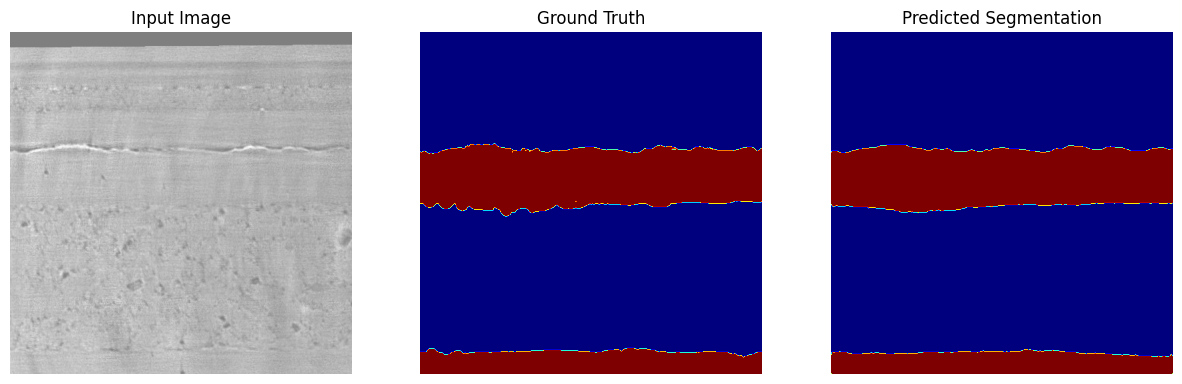

In [38]:
import matplotlib.pyplot as plt
import torch

# denormalization function
def denormalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    img = img * torch.tensor(std).view(1,1,3) + torch.tensor(mean).view(1,1,3)
    img = torch.clamp(img, 0, 1)
    return img

# set the dataset image index you want to visualize
dataset_idx = 1  

# get image and label from the dataset
img, label = train_dataset[dataset_idx]  # or val_dataset
img = img.unsqueeze(0)    # add batch dimension [1, C, H, W]
label = label.unsqueeze(0)  # [1,H,W] or [1,1,H,W]

# move to device
img = img.to(device)

# predict
model.eval()
with torch.no_grad():
    output = model(img)
    pred = torch.argmax(output, dim=1)

# convert tensors to lists for plotting
img_plot = denormalize(img[0].cpu().permute(1, 2, 0)).tolist()
label_plot = label[0].cpu().squeeze().tolist()
pred_plot = pred[0].cpu().tolist()

# plot the input ,gt, and prediction
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].imshow(img_plot)
axs[0].set_title("Input Image")
axs[0].axis('off')

axs[1].imshow(label_plot, cmap='jet')
axs[1].set_title("Ground Truth")
axs[1].axis('off')

axs[2].imshow(pred_plot, cmap='jet')
axs[2].set_title("Predicted Segmentation")
axs[2].axis('off')

plt.show()
